# Predicting calories burned from exercise data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

exercise_df = pd.read_csv('exercise.csv', low_memory=False)
calories_df = pd.read_csv('calories.csv', low_memory=False)

2.4.1


## Prepare Data

Merge exercise and calories tables

In [2]:
del calories_df['User_ID']
del exercise_df['User_ID']
df = pd.concat([exercise_df, calories_df], axis=1)
df.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,female,27,154.0,58.0,10.0,81.0,39.8,35.0


Remove rows with missing values

In [3]:
df.isna().sum()

Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [4]:
df = df.dropna()

Map `gender` column into separate `male` and `female` columns

In [5]:
df['Gender'] = df['Gender'].map({'male': 'male', 'female': 'female'})
df = pd.get_dummies(df, columns=['Gender'], prefix='', prefix_sep='')
df.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,female,male
0,68,190.0,94.0,29.0,105.0,40.8,231.0,0,1
1,20,166.0,60.0,14.0,94.0,40.3,66.0,1,0
2,69,179.0,79.0,5.0,88.0,38.7,26.0,0,1
3,34,179.0,71.0,13.0,100.0,40.5,71.0,1,0
4,27,154.0,58.0,10.0,81.0,39.8,35.0,1,0


Split into testing and training

In [6]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

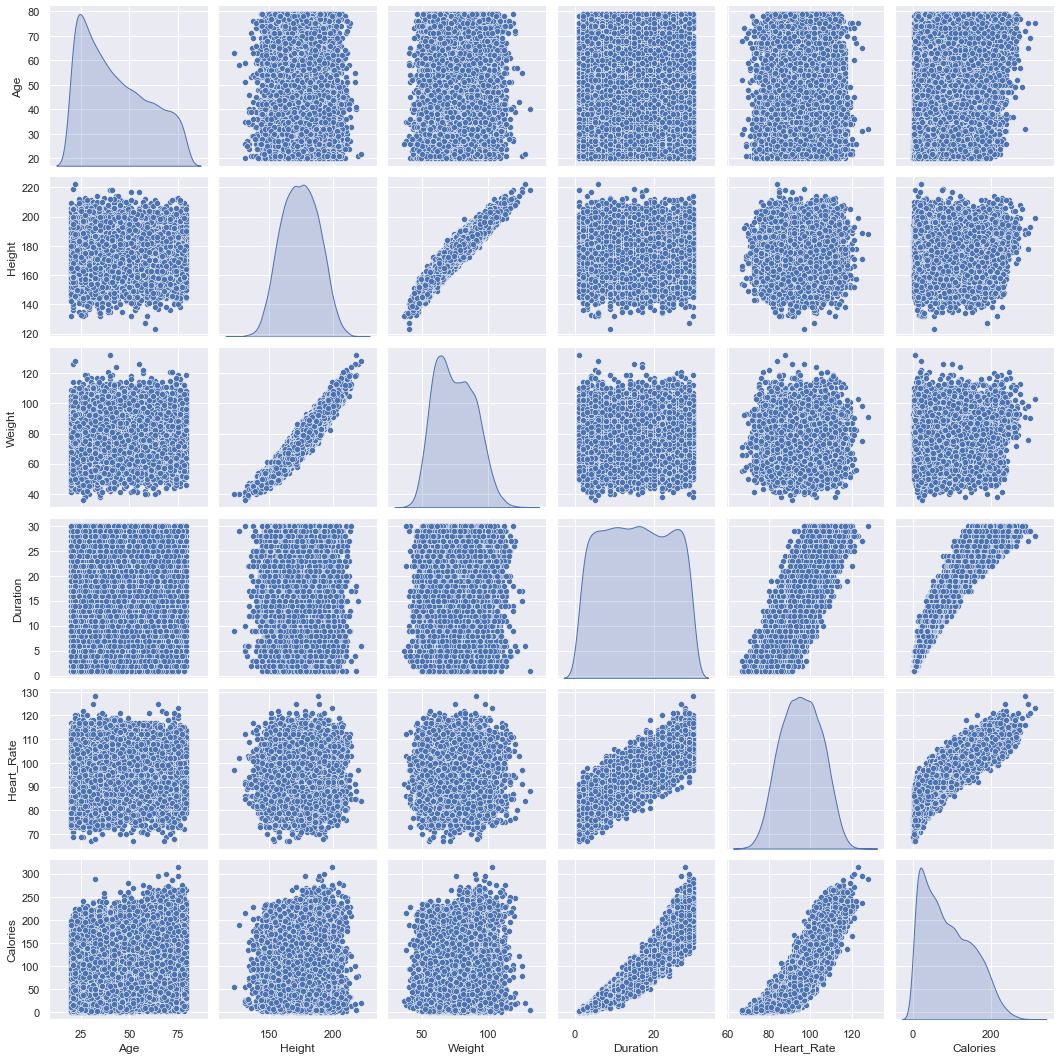

In [7]:
sns.pairplot(train_dataset[['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Calories']], diag_kind='kde')

In [8]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,12000.0,42.748833,17.019329,20.0,28.0,39.0,56.0,79.0
Height,12000.0,174.333583,14.256165,123.0,164.0,174.0,185.0,222.0
Weight,12000.0,74.841917,15.025791,36.0,63.0,74.0,86.0,132.0
Duration,12000.0,15.543500,8.306425,1.0,8.0,16.0,23.0,30.0
Heart_Rate,12000.0,95.562833,9.590302,67.0,88.0,96.0,103.0,128.0
Body_Temp,12000.0,40.029217,0.776528,37.1,39.6,40.2,40.6,41.5
Calories,12000.0,89.621000,62.480310,1.0,35.0,79.0,137.0,314.0
female,12000.0,0.507000,0.499972,0.0,0.0,1.0,1.0,1.0
male,12000.0,0.493000,0.499972,0.0,0.0,0.0,1.0,1.0


In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Calories')
test_labels = test_features.pop('Calories')

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Age,42.748833,17.019329
Height,174.333583,14.256165
Weight,74.841917,15.025791
Duration,15.543500,8.306425
Heart_Rate,95.562833,9.590302
Body_Temp,40.029217,0.776528
Calories,89.621000,62.480310
female,0.507000,0.499972
male,0.493000,0.499972


Normalize data

In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

[ 42.748833 174.33359   74.84192   15.5435    95.562836  40.029217
   0.507      0.493   ]
First example: [[ 27.  170.   66.    9.   94.   39.8   1.    0. ]]

Normalized: [[-0.93 -0.3  -0.59 -0.79 -0.16 -0.3   0.99 -0.99]]


## Models

### Linear Regression

#### One Variable

In [12]:
heart_rate = np.array(train_features['Heart_Rate'])

heart_rate_normalizer = preprocessing.Normalization(input_shape=[1,])
heart_rate_normalizer.adapt(heart_rate)

In [13]:
heart_rate_model = tf.keras.Sequential([
    heart_rate_normalizer,
    layers.Dense(units=1)
])

heart_rate_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [14]:
heart_rate_model.predict(heart_rate[:10])

array([[-0.09269289],
       [-0.80442137],
       [-0.03338218],
       [ 0.91558915],
       [ 0.4411035 ],
       [ 0.20386064],
       [ 0.32248208],
       [ 0.32248208],
       [ 0.6190356 ],
       [ 0.08523924]], dtype=float32)

In [15]:
heart_rate_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [16]:
%%time
history = heart_rate_model.fit(
    train_features['Heart_Rate'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 24.3 s, sys: 4.46 s, total: 28.8 s
Wall time: 20.1 s


In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,21.700308,21.803406,95
96,21.707180,21.769951,96
97,21.691921,21.808022,97
98,21.700424,21.733561,98
99,21.698145,21.767944,99


In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Calories]')
  plt.legend()
  plt.grid(True)

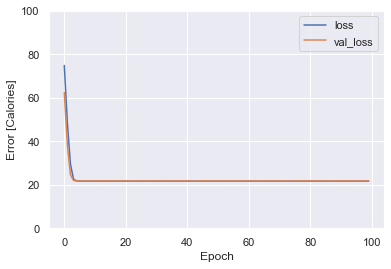

In [19]:
plot_loss(history)

In [20]:
test_results = {}

test_results['heart_rate_model'] = heart_rate_model.evaluate(
    test_features['Heart_Rate'],
    test_labels, verbose=0)

In [21]:
x = tf.linspace(0.0, 250, 251)
y = heart_rate_model.predict(x)

In [22]:
def plot_heart_rate(x, y):
  plt.scatter(train_features['Heart_Rate'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('heart rate')
  plt.ylabel('calories burned')
  plt.legend()

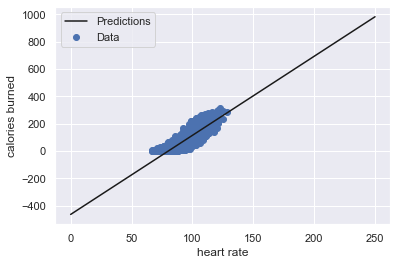

In [23]:
plot_heart_rate(x, y)

#### Multivariable

In [24]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

array([[ 1.5324414 ],
       [ 1.0618756 ],
       [-0.14088011],
       [-1.8722687 ],
       [-0.9497103 ],
       [-1.6807983 ],
       [-1.3630667 ],
       [-0.86011744],
       [-1.2769375 ],
       [-0.9364251 ]], dtype=float32)

In [25]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[-0.5057783 ],
       [-0.22736925],
       [ 0.2362765 ],
       [-0.49578193],
       [-0.10333502],
       [-0.5873921 ],
       [ 0.03707451],
       [-0.5242431 ]], dtype=float32)>

In [26]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [27]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 24.2 s, sys: 4.14 s, total: 28.3 s
Wall time: 18.6 s


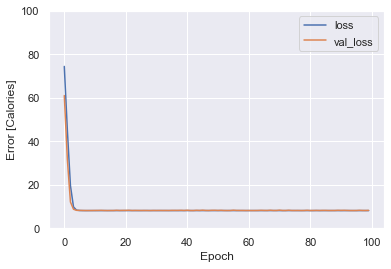

In [28]:
plot_loss(history)

In [29]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### DNN

#### Single Input

In [30]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [31]:
dnn_heart_rate_model = build_and_compile_model(heart_rate_normalizer)

In [32]:
dnn_heart_rate_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [33]:
%%time
history = dnn_heart_rate_model.fit(
    train_features['Heart_Rate'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 55.8 s, sys: 14.1 s, total: 1min 9s
Wall time: 34.8 s


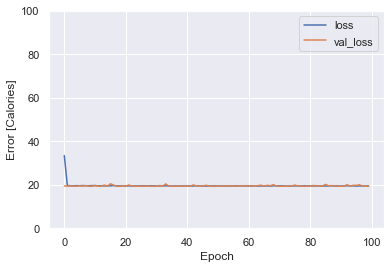

In [34]:
plot_loss(history)

In [35]:
x = tf.linspace(0.0, 250, 251)
y = dnn_heart_rate_model.predict(x)

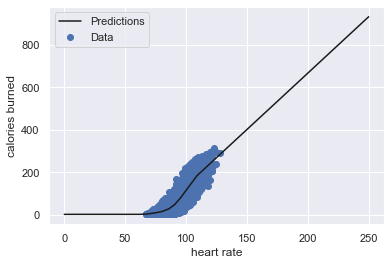

In [36]:
plot_heart_rate(x, y)

In [37]:
test_results['dnn_heart_rate_model'] = dnn_heart_rate_model.evaluate(
    test_features['Heart_Rate'], test_labels,
    verbose=0)

#### Multi input

In [38]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [39]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1min 3s, sys: 16.5 s, total: 1min 19s
Wall time: 41.2 s


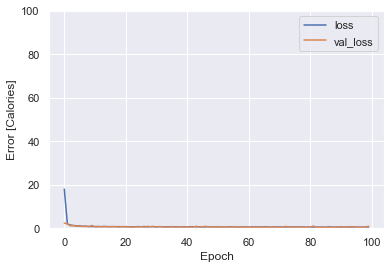

In [40]:
plot_loss(history)

In [41]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [42]:
pd.DataFrame(test_results, index=['Mean asbolute error [calories_burned]']).T

,Mean asbolute error [calories_burned]
heart_rate_model,21.722893
linear_model,7.923700
dnn_heart_rate_model,19.555933
dnn_model,0.945784


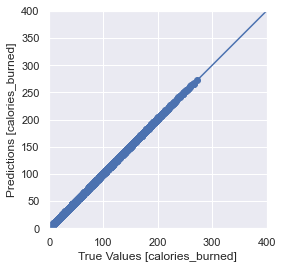

In [43]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [calories_burned]')
plt.ylabel('Predictions [calories_burned]')
lims = [0, 400]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

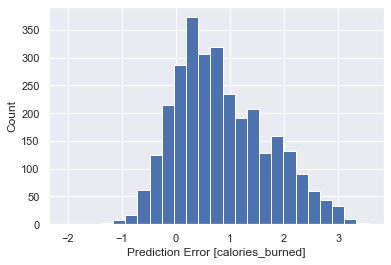

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [calories_burned]')
_ = plt.ylabel('Count')

In [45]:
dnn_model.save('dnn_calories_model')

INFO:tensorflow:Assets written to: dnn_calories_model/assets


## Results Summary:

The multi input DNN is extremely accurate and can be used for the app. The model has been saved as 'dnn_calories_model.' This model can be used to predict calories burned from an exercise given various factors such as personal information (age, weight, height), and exercise data (duration, heart rate).